# Regularization with SciKit-Learn

Previously we created a new polynomial feature set and then applied our standard linear regression on it, but we can be smarter about model choice and utilize regularization.

Regularization attempts to minimize the RSS (residual sum of squares) *and* a penalty factor. This penalty factor will penalize models that have coefficients that are too large. Some methods of regularization will actually cause non useful features to have a coefficient of zero, in which case the model does not consider the feature.

Let's explore two methods of regularization, Ridge Regression and Lasso. We'll combine these with the polynomial feature set (it wouldn't be as effective to perform regularization of a model on such a small original feature set of the original X).

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data and Setup

In [2]:
df = pd.read_csv("Advertising.csv")
X = df.drop('sales',axis=1)
y = df['sales']

In [3]:
X

,TV,radio,newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4
...,...,...,...
195,38.2,3.7,13.8
196,94.2,4.9,8.1
197,177.0,9.3,6.4
198,283.6,42.0,66.2


In [4]:
y

0      22.1
1      10.4
2       9.3
3      18.5
4      12.9
       ... 
195     7.6
196     9.7
197    12.8
198    25.5
199    13.4
Name: sales, Length: 200, dtype: float64

### Polynomial Conversion

In [5]:
from sklearn.preprocessing import PolynomialFeatures

In [6]:
polynomial_converter = PolynomialFeatures(degree=3,include_bias=False)

In [7]:
poly_features = polynomial_converter.fit_transform(X)

In [8]:
poly_features[0]

array([2.30100000e+02, 3.78000000e+01, 6.92000000e+01, 5.29460100e+04,
       8.69778000e+03, 1.59229200e+04, 1.42884000e+03, 2.61576000e+03,
       4.78864000e+03, 1.21828769e+07, 2.00135918e+06, 3.66386389e+06,
       3.28776084e+05, 6.01886376e+05, 1.10186606e+06, 5.40101520e+04,
       9.88757280e+04, 1.81010592e+05, 3.31373888e+05])

### Train | Test Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

----
----

## Scaling the Data

While our particular data set has all the values in the same order of magnitude ($1000s of dollars spent), typically that won't be the case on a dataset, and since the mathematics behind regularized models will sum coefficients together, its important to standardize the features. Review the theory videos for more info, as well as a discussion on why we only **fit** to the training data, and **transform** on both sets separately.

In [13]:
from sklearn.preprocessing import StandardScaler

In [9]:
# help(StandardScaler)

In [14]:
scaler = StandardScaler()

In [15]:
scaler.fit(X_train)

StandardScaler()

In [16]:
X_train = scaler.transform(X_train)

In [17]:
X_test = scaler.transform(X_test)

## Ridge Regression

Make sure to view video lectures for full explanation of Ridge Regression and choosing an alpha.

In [18]:
from sklearn.linear_model import Ridge

In [19]:
ridge_model = Ridge(alpha=10)

In [20]:
ridge_model.fit(X_train,y_train)

Ridge(alpha=10)

In [21]:
test_predictions = ridge_model.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [23]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [24]:
MAE

0.5774404204714166

In [25]:
RMSE

0.8946386461319648

How did it perform on the training set? (This will be used later on for comparison)

In [26]:
# Training Set Performance
train_predictions = ridge_model.predict(X_train)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

0.5288348183025304

### Choosing an alpha value with Cross-Validation

Review the theory video for full details.

In [27]:
from sklearn.linear_model import RidgeCV

In [24]:
# help(RidgeCV)

In [28]:
# Choosing a scoring: https://scikit-learn.org/stable/modules/model_evaluation.html
# Negative RMSE so all metrics follow convention "Higher is better"

# See all options: sklearn.metrics.SCORERS.keys()
ridge_cv_model = RidgeCV(alphas=(0.01,0.1, 1.0, 10.0),scoring='neg_mean_absolute_error')

In [29]:
# The more alpha options you pass, the longer this will take.
# Fortunately our data set is still pretty small
ridge_cv_model.fit(X_train,y_train)

RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), scoring='neg_mean_absolute_error')

4 models have been trained: you can now ask what alpha was chosen as best.

In [30]:
ridge_cv_model.alpha_

0.01

In [31]:
test_predictions = ridge_cv_model.predict(X_test)

In [32]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [33]:
MAE

0.4101873183288653

In [34]:
RMSE

0.5829610859820523

In [35]:
# Training Set Performance
# Training Set Performance
train_predictions = ridge_cv_model.predict(X_train)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

0.28912714580437177

In [36]:
ridge_cv_model.coef_

array([ 6.9038259 ,  0.49047734,  0.29464737, -9.7103904 ,  5.06456503,
       -1.66613758, -1.30427348,  0.76860722,  0.35722042,  4.58992377,
       -1.52624141,  1.42375451,  0.43356846, -0.31710017,  0.03883517,
        0.71412093, -0.3097189 , -0.21689709, -0.24610412])

Coefficient values for the entire model: cannot be zero in Ridge Regression


-----

## Lasso Regression

In [37]:
from sklearn.linear_model import LassoCV

In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
lasso_cv_model = LassoCV(eps=0.1,n_alphas=100,cv=5)

In [39]:
lasso_cv_model.fit(X_train,y_train)

LassoCV(cv=5, eps=0.1)

In [40]:
lasso_cv_model.alpha_

0.4943070909225831

In [41]:
test_predictions = lasso_cv_model.predict(X_test)

In [42]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [43]:
MAE

0.6541723161252868

In [44]:
RMSE

1.1308001022762548

In [45]:
# Training Set Performance
# Training Set Performance
train_predictions = lasso_cv_model.predict(X_train)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

0.691280714082071

In [46]:
lasso_cv_model.coef_

array([1.002651  , 0.        , 0.        , 0.        , 3.79745279,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

coefficient values can be zero in Lasso, which makes it useful for feature selection

## Elastic Net

Elastic Net combines the penalties of ridge regression and lasso in an attempt to get the best of both worlds!

In [47]:
from sklearn.linear_model import ElasticNetCV

In [48]:
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01)

In [49]:
elastic_model.fit(X_train,y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], tol=0.01)

In [50]:
elastic_model.l1_ratio_

1.0

In [51]:
test_predictions = elastic_model.predict(X_test)

In [52]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [53]:
MAE

0.566326211756945

In [54]:
RMSE

0.7485546215633726

In [55]:
# Training Set Performance
# Training Set Performance
train_predictions = elastic_model.predict(X_train)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

0.4307582990472368

In [56]:
elastic_model.coef_

array([ 3.78993643,  0.89232919,  0.28765395, -1.01843566,  2.15516144,
       -0.3567547 , -0.271502  ,  0.09741081,  0.        , -1.05563151,
        0.2362506 ,  0.07980911,  1.26170778,  0.01464706,  0.00462336,
       -0.39986069,  0.        ,  0.        , -0.05343757])

coefficient values can be zero in Lasso, which makes it useful for feature selection

-----
---

Consider the "auto-mpg.csv" datafile. 

Analyze this dataset using polynomial regression.


Start off by constructing a correlation matrix to check which variables
might interact with each other.


Use both polynomial as linear regression to fit the best possible models,
and formulate a prediction.


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
mpg = pd.read_csv('auto-mpg.csv')
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [99]:
mpgDrop = mpg.drop('car name', axis=1)
mpgDrop.head()  

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [112]:
mpgDrop["horsepower"] = mpgDrop["horsepower"].apply(pd.to_numeric, errors='coerce')
mpgDrop = mpgDrop.dropna()

In [117]:
mpgDrop

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


<Axes: >

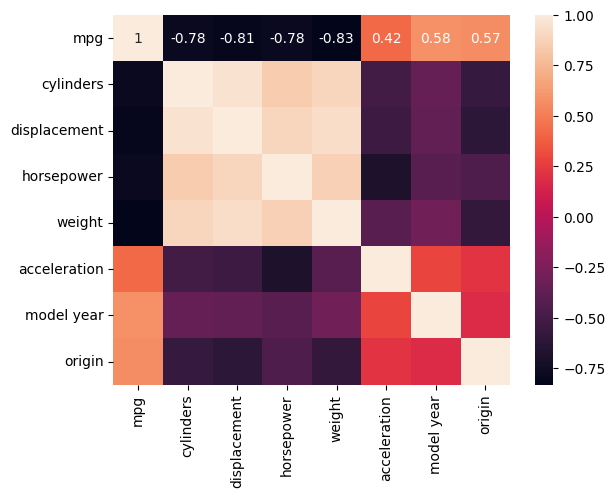

In [118]:
#heatmap
sns.heatmap(mpgDrop.corr(), annot=True)

In [121]:
X = mpgDrop.drop("mpg", axis=1)
Y = mpgDrop['mpg']
X

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,8,307.0,130.0,3504,12.0,70,1
1,8,350.0,165.0,3693,11.5,70,1
2,8,318.0,150.0,3436,11.0,70,1
3,8,304.0,150.0,3433,12.0,70,1
4,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790,15.6,82,1
394,4,97.0,52.0,2130,24.6,82,2
395,4,135.0,84.0,2295,11.6,82,1
396,4,120.0,79.0,2625,18.6,82,1


In [122]:
Y

0      18.0
1      15.0
2      18.0
3      16.0
4      17.0
       ... 
393    27.0
394    44.0
395    32.0
396    28.0
397    31.0
Name: mpg, Length: 392, dtype: float64

polynomal conversion

In [104]:
from sklearn.preprocessing import PolynomialFeatures

In [105]:
polCon = PolynomialFeatures(degree=2, include_bias= False)


In [123]:
polFeat = polCon.fit_transform(X)

In [124]:
polFeat[0]

array([8.0000000e+00, 3.0700000e+02, 1.3000000e+02, 3.5040000e+03,
       1.2000000e+01, 7.0000000e+01, 1.0000000e+00, 6.4000000e+01,
       2.4560000e+03, 1.0400000e+03, 2.8032000e+04, 9.6000000e+01,
       5.6000000e+02, 8.0000000e+00, 9.4249000e+04, 3.9910000e+04,
       1.0757280e+06, 3.6840000e+03, 2.1490000e+04, 3.0700000e+02,
       1.6900000e+04, 4.5552000e+05, 1.5600000e+03, 9.1000000e+03,
       1.3000000e+02, 1.2278016e+07, 4.2048000e+04, 2.4528000e+05,
       3.5040000e+03, 1.4400000e+02, 8.4000000e+02, 1.2000000e+01,
       4.9000000e+03, 7.0000000e+01, 1.0000000e+00])

In [125]:
from sklearn.model_selection import train_test_split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(polFeat, y, test_size=0.3, random_state=101)

In [127]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [128]:
scaler.fit(X_train)

StandardScaler()

check voor alpha

In [129]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
from sklearn.linear_model import ElasticNetCV
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01)
elastic_model.fit(X_train,y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], tol=0.01)

In [141]:
elastic_model.l1_ratio_

0.5

In [142]:
test_predictions = elastic_model.predict(X_test)

In [143]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [144]:
MAE

1.8822620154253356

In [145]:
MSE

6.842054431093905

In [146]:
RMSE

2.615732102317419

In [147]:
elastic_model.coef_

array([-0.        , -0.49381147,  0.        , -1.00550924, -0.82568451,
        0.88295465,  0.03268631, -0.        ,  0.        ,  0.1320355 ,
        0.71140792,  0.37826394, -1.23244586,  1.09535612,  0.15326179,
        1.07233662,  1.30922578, -0.97781942, -2.31511024,  0.83164747,
        1.28497208,  0.95179079, -1.00448101, -1.79038561, -1.52351965,
        1.03027361, -0.65380917, -2.83510532, -0.69809661,  0.44654036,
        0.59034434,  1.96343286,  2.84658513,  0.63584343, -1.6557472 ])

In [150]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Initialize linear regression model
linear_reg = LinearRegression()

# Fit the linear regression model
linear_reg.fit(X_train, y_train)

# Make predictions with linear regression model
y_pred_linear = linear_reg.predict(X_test)

linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))
linear_r2 = r2_score(y_test, y_pred_linear)
print(f"Linear Regression RMSE: {linear_rmse:.2f}, R-squared: {linear_r2:.2f}")


Linear Regression RMSE: 2.80, R-squared: 0.85
